# Machine Learning Models 

#### Here you will find the ML applications on the female population of the sample. These applications include training of models, rule extraction and feature analysis.
#### If you wish to learn more, please visit our [README.md file](../../README.md) or read the [full report](../../Report/TF_citas_rapidas.pdf) (spanish version only) 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from feature_analysis import *
from model_fitting import *
from funciones import *
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
import warnings
from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%config inlinebackend.figure_format = 'retina'
%matplotlib Inline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

For more information on processing, please refer to the [*preprocessing*](../Preprocessing/preprocessing.ipynb) notebook 

In [2]:
train_path = '../Datasets//df_imput.parquet'
test_path = '../Datasets//test_imput.parquet'
df = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

#### Now that the data is loaded into the notebook, we'll keep female subject observations only 

In [4]:
df_m,df_f = df.loc[df['male'] == 1].copy(),df.loc[df['male'] == 0].copy()
X_train_m,X_train_f = df.loc[df['male'] == 1].drop(columns = ['decision']).copy(),df.loc[df['male'] == 0].drop(columns = ['decision']).copy()
y_train_m,y_train_f = df['decision'].loc[df['male'] == 1].copy(),df['decision'].loc[df['male'] == 0].copy()
X_test_m,X_test_f = test.loc[test['male'] == 1].drop(columns = ['decision']).copy(),test.loc[test['male'] == 0].drop(columns = ['decision']).copy()
y_test_m,y_test_f = test['decision'].loc[test['male'] == 1].copy(),test['decision'].loc[test['male'] == 0].copy()
del df_m #To save memory

#### Standardizing

In [5]:
vars_to_standardize = []
for i in X_train_f.columns:
    if len(X_train_f[i].unique()) > 2: #Excluye dicotómicas
        vars_to_standardize.append(i)
scaler = StandardScaler()
X_train_f[vars_to_standardize] = scaler.fit_transform(X_train_f[vars_to_standardize].values)
X_test_f[vars_to_standardize] = scaler.fit_transform(X_test_f[vars_to_standardize].values)
df_f[vars_to_standardize] = scaler.fit_transform(df_f[vars_to_standardize].values)

### Grid search to Find the optimal model for creating rules

In [6]:
kappa = make_scorer(cohen_kappa_score)

In [ ]:
random_search = find_best_model(X_train_f,y_train_f,kappa)

In [8]:
gb = GradientBoostingClassifier(
    verbose=5,
    **random_search.best_params_,
)

In [9]:
random_search.best_params_

{'n_estimators': 3000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 2,
 'learning_rate': 0.05}

In [ ]:
gb.fit(X_train_f,y_train_f)

In [11]:
y_test_pred_f = gb.predict(X_test_f)
cohen_kappa_score(y_test_f,y_test_pred_f) #Sanity check # OK

0.6515460799879036

In [ ]:
gb.get_params()

##### Now with the trained model, we can extract rules which will serve as predictors for simpler, more interpretable models
see [Friedman, J. H. and Popescu, B. E. (2005). "Predictive Learning via Rule Ensembles"](https://arxiv.org/pdf/0811.1679.pdf)

In [13]:
original_features = df.drop(columns=['decision']).columns.to_list() #Keeping a list of the original columns for feature analysis

In [27]:
rules = select_random_rules(gb,X_train_f[original_features],number_of_rules = 50,branch_lengths=[2,3],verbose=1,max_trees=500)
## Takes a long time, so we'll just extract 50 rules max for demonstration purposes. Originally it was set at 1000 rules

Getting rules from tree n°100
Getting rules from tree n°200
Getting rules from tree n°300
Getting rules from tree n°400
Selecting random rules
Returning rules


In [31]:
len(rules) #Perfect

50

In [32]:
X_train_f = X_train_f[original_features]
X_test_f = X_test_f[original_features]

##### And now we can make new columns out of the extracted rules:

In [34]:
for rule in rules:
    col_name = col_name_from_rule(rule)
    X_train_f[col_name] = make_column_from_rule(X_train_f,rule = rule) 
    X_test_f[col_name] = make_column_from_rule(X_test_f,rule = rule)     

## Logit Model (Lasso). 
Essentially we fit various (penalized) logit models using the original columns and the extracted rules.
For an intuitive explanation of regularization, the reader can take a look at 

[T. Hastie, R. Tibshirani, D. Witten and G. James, “An Introduction to Statistical Learning With Applications in R”, 2nd ed. 2021](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/6009dd9fa7bc363aa822d2c7/1611259312432/ISLR+Seventh+Printing.pdf)

In [ ]:
metrics_f = dict(
    C = [0.01,0.05,0.1,0.3,0.5],
    kapp = [],
    acc = [],
    acc_train = [],
    kapp_train = [],
    n_feats = []
)
vals = dict(ranks = [])
for C in [0.01,0.05,0.1,0.3,0.5]: #Hyper parameter tuning and saving the kappa values for later plotting
    print('Going for C = {}'.format(C))
    l_reg = LogisticRegression(C = C, penalty= 'l1', solver= 'liblinear',verbose=5)
    selector = RFECV( #Feature selection; this is where the best predictors (rules) will be picked up.
    estimator=l_reg,
    step=1,
    scoring=kappa,
    cv = 5,
    n_jobs=-1,
    verbose = 10
    )
    selector.fit(X_train_f,y_train_f)
    y_pred_f_log = selector.predict(X_test_f)
    y_pred_f_log_train = selector.predict(X_train_f)
    kap = cohen_kappa_score(y_pred_f_log,y_test_f) #Kappa is lower than GB model's!
    accuracy = accuracy_score(y_pred_f_log,y_test_f)
    kap_train = cohen_kappa_score(y_pred_f_log_train,y_train_f)
    accuracy_train = accuracy_score(y_pred_f_log_train,y_train_f)
    vars = zip(selector.get_feature_names_out(),selector.ranking_)
    vars = pd.DataFrame(vars,columns=['feature','rank'])
    vars.sort_values(by='rank',ascending=True,inplace=True)
    n_features = selector.n_features_
    metrics_f['kapp'].append(kap)
    metrics_f['acc'].append(accuracy)
    metrics_f['acc_train'].append(accuracy_train)
    metrics_f['kapp_train'].append(kap_train)
    vals['ranks'].append(vars)
    metrics_f['n_feats'].append(n_features)


In [41]:
metrics_f = dict( #This time without "recursive feature elimination". In the paper it was done that way, but we were getting a lot of features for large values of "C"
    # Feature selection is already taken care of by regularization ("L1") itself!
    C = [0.01,0.05,0.1,0.3,0.5],
    kapp = [],
    acc = [],
    acc_train = [],
    kapp_train = [],
    n_feats = []
) 
vals = dict(
    ranks = []
)
for C in [0.01,0.05,0.1,0.3,0.5]:
    log_reg = LogisticRegression(
        C = C, penalty= 'l1', solver= 'liblinear',verbose=5,

    )
    log_reg.fit(X_train_f,y_train_f)
    y_pred_f_log = log_reg.predict(X_test_f)
    y_pred_f_log_train = log_reg.predict(X_train_f)
    kap = cohen_kappa_score(y_pred_f_log,y_test_f) #Menor kappa que el GB!
    accuracy = accuracy_score(y_pred_f_log,y_test_f)
    kap_train = cohen_kappa_score(y_pred_f_log_train,y_train_f)
    accuracy_train = accuracy_score(y_pred_f_log_train,y_train_f)
    vars = pd.DataFrame(log_reg.coef_[0],index=log_reg.feature_names_in_,columns=['coef'])
    vars = vars.loc[vars['coef'] != 0]
    vals['ranks'].append(vars.sort_values(by='coef',ascending=False))
    n_features = len(vars)
    metrics_f['kapp'].append(kap)
    metrics_f['acc'].append(accuracy)
    metrics_f['n_feats'].append(n_features)
    metrics_f['acc_train'].append(accuracy_train)
    metrics_f['kapp_train'].append(kap_train)
    


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

## Plots 
(They aren't going to be exactly the same as those on the report, since a few of the steps involve some kind of randomness)

In [42]:
plots_log_f = pd.DataFrame(metrics_f)
C = [np.int(i**-1) for i in metrics_f['C']]
plots_log_f.index = C
plots_log_f.rename(columns={'kapp':'kappa_test','kapp_train':'kappa_train',
                            'acc':'accuracy_test','acc_train':'accuracy_train',
                            'n_feats':'n° features'},inplace=True)
plots_log_f.drop(columns=['C'],inplace=True)

In [ ]:
metrics_f

In [44]:
plots_log_f

,kappa_test,accuracy_test,accuracy_train,kappa_train,n° features
100,0.562084,0.804296,0.767596,0.478593,15
20,0.582316,0.811456,0.794688,0.543908,53
10,0.557773,0.799523,0.803984,0.564490,72
3,0.588188,0.811456,0.817795,0.599248,97
2,0.585860,0.811456,0.815405,0.594437,101


### And here the best model uses "C" = 0.3, which is, again, different from what we get in the paper. Since this is for demonstration purposes only, readers will have to excuse the discrepancy

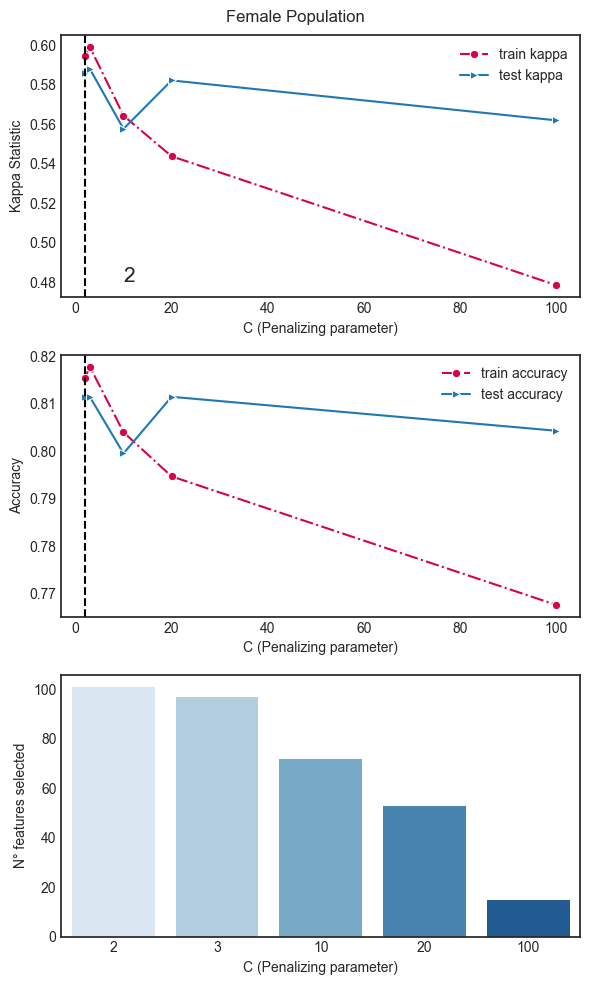

In [45]:
with plt.style.context('seaborn-v0_8-white'):
    fig, axes = plt.subplots(3,1,figsize=(6,10))
    sns.lineplot(data=plots_log_f,x=plots_log_f.index,y='kappa_train',ax=axes[0],label='train kappa',color='#d9024a',ls='-.',marker='o')
    sns.lineplot(data=plots_log_f,x=plots_log_f.index,y='kappa_test',ax=axes[0],label='test kappa',marker='>')
    sns.lineplot(data=plots_log_f,x=plots_log_f.index,y='accuracy_train',ax=axes[1],label='train accuracy',color='#d9024a',ls='-.',marker='o')
    sns.lineplot(data=plots_log_f,x=plots_log_f.index,y='accuracy_test',ax=axes[1],label='test accuracy',marker='>')
    sns.barplot(data=plots_log_f,x=plots_log_f.index,y='n° features',ax=axes[2],label='n° variables',palette='Blues')
    axes[0].annotate(0.63,xy=(10,0.63))
    axes[1].annotate(0.83,xy=(10,0.83))
    axes[0].set(ylabel = 'Kappa Statistic')
    axes[0].axvline(x = 2, color = 'black',ls='--')
    axes[0].annotate('2',xy=(10,0.48),fontsize=15)
    axes[1].set(ylabel = 'Accuracy')
    axes[1].axvline(x = 2, color = 'black',ls='--')
    axes[1].annotate('2',xy=(10,0.76),fontsize=15)
    axes[2].set(ylabel='N° features selected')
    fig.suptitle('Female Population')
    for ax in axes:
        ax.set_xlabel('C (Penalizing parameter)')
    plt.tight_layout()
    save_path = 'Plots//lasso_f.jpeg'
    #plt.savefig(save_path,dpi = 300) No need to save the fig
    plt.show()

#### Feature Importance

In [51]:
### We want a separate model, not just "best_estimator", etc.:
lasso = LogisticRegression(C = 0.3, penalty= 'l1', solver= 'liblinear')
lasso.fit(X_train_f[vals['ranks'][-2].index.to_list()],y_train_f) #The "vals" dictionary contains every selected feature for each of the possible "C" values


LogisticRegression(C=0.3, penalty='l1', solver='liblinear')

In [53]:
original_features = df.drop(columns=['decision']).columns.to_list()
selected_feats = vals['ranks'][-2].index.to_list()

### Selected Features :

In [ ]:
linear_vars = [i for i in selected_feats if i in original_features] #Only these were selected (not counting interactions)
linear_vars

In [ ]:
# Feat. Importace calculation (a bit overcomplicated maybe)
feature_importance = dict(
    feature = list(),
    lasso_train_importance = list(),
    lasso_test_importance = list(),
    GB_train_importance = list(),
    GB_test_importance = list(),
)
for feat in original_features:
    if feat in selected_feats:
        feature_importance['lasso_train_importance'].append(calcular_feat_importance(
            feat,X_train_f[selected_feats],y_train_f,lasso,cohen_kappa_score,selected_feats,n_iter=10000))
        feature_importance['lasso_test_importance'].append(calcular_feat_importance(
            feat,X_test_f[selected_feats],y_test_f,lasso,cohen_kappa_score,selected_feats,n_iter=10000))
        print(feat)
    else:
        feature_importance['lasso_train_importance'].append(np.nan) #Some didn't make it to the model and are therefore "Nans"
        feature_importance['lasso_test_importance'].append(np.nan)

    feature_importance['GB_train_importance'].append(calcular_feat_importance(
        feat,X_train_f[gb.feature_names_in_],y_train_f,gb,cohen_kappa_score,gb.feature_names_in_,verbose=1))
    feature_importance['GB_test_importance'].append(calcular_feat_importance(
        feat,X_test_f[gb.feature_names_in_],y_test_f,gb,cohen_kappa_score,gb.feature_names_in_))
    feature_importance['feature'].append(feat)

In [56]:
feature_importance = pd.DataFrame(feature_importance,index=feature_importance['feature'])
feature_importance.drop(columns=['feature'],inplace=True)

#### Plots

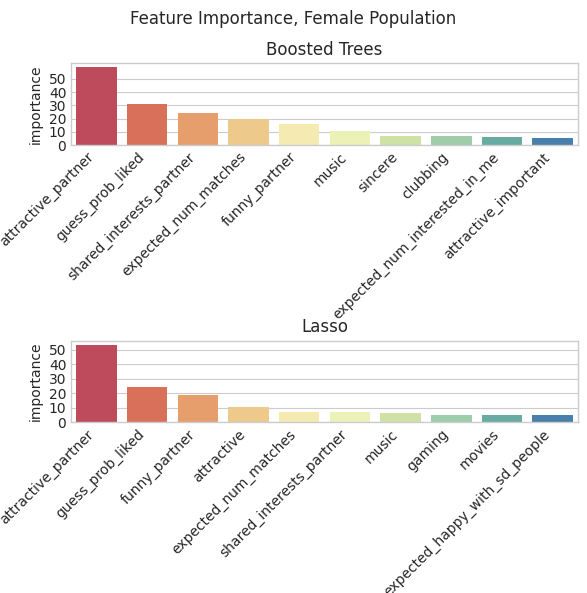

In [57]:
gb_FI = feature_importance['GB_test_importance'].sort_values(ascending=False).head(10) #Los 10 más importantes
lasso_FI = feature_importance['lasso_test_importance'].sort_values(ascending=False).head(10) 
with plt.style.context('seaborn-v0_8-whitegrid'): 
    fig,axes = plt.subplots(2,1,figsize = (6,6))
    sns.barplot(x=gb_FI.index,y=gb_FI,ax=axes[0],palette='Spectral')
    axes[0].set_xticklabels(gb_FI.index,rotation=45, ha='right')
    axes[0].set(title='Boosted Trees')
    axes[0].set_yticks(np.arange(0,60,10))
    axes[0].set_ylabel('importance')
    axes[0].tick_params(axis='both', which='minor', labelsize=8)
    sns.barplot(x=lasso_FI.index,y=lasso_FI,ax=axes[1],palette='Spectral')
    axes[1].set_xticklabels(lasso_FI.index,rotation=45, ha='right')
    axes[1].set_ylabel('importance')
    axes[1].set(title='Lasso')
    axes[1].set_yticks(np.arange(0,60,10))
    axes[0].tick_params(axis='both', which='minor', labelsize=8)
    fig.suptitle('Feature Importance, Female Population')
    plt.tight_layout()
    save_path = 'Plots//feat_importance_f.jpeg'
    #plt.savefig(save_path,dpi=300) No need to save this time

## Despite the small differences, our conclusions are the same

### Coeficients
Since there is regularization involved, we can't run t-tests or get the standard errors

In [60]:
lasso_coefs = pd.DataFrame(lasso.coef_.reshape(-1,1),index=lasso.feature_names_in_,columns=['coef'])
lasso_coefs = lasso_coefs.loc[linear_vars]
lasso_coefs = pd.concat([lasso_coefs,feature_importance['lasso_test_importance'].sort_values(ascending=False).head(16)],axis=1)
lasso_coefs.sort_values(by = 'lasso_test_importance',ascending = False) 


,coef,lasso_test_importance
attractive_partner,0.745482,53.51
guess_prob_liked,0.503450,24.06
funny_partner,0.517660,19.13
attractive,0.125622,10.74
expected_num_matches,0.080113,7.27
shared_interests_partner,0.133030,6.88
music,-0.202170,6.62
gaming,0.002463,5.30
movies,-0.047368,4.90
expected_happy_with_sd_people,0.130955,4.89


### Partial Dependence

Selecting the 5 most important features. Also, we're plotting some of the features used in the (original) [paper](http://www.stat.columbia.edu/~gelman/stuff_for_blog/sheena.pdf) to compare against their results

In [61]:
calculate_partial_dependence('attractive_partner',X_test_f[selected_feats],lasso,selected_feats)[1]

,Partial Dependence
attractive_partner,
-2.466906,0.1232
-1.966115,0.1566
-1.465323,0.1956
-0.964532,0.2400
-0.463740,0.2894
0.037051,0.3429
0.537843,0.3996
1.038634,0.4581
1.539426,0.5172


In [62]:
feats_paper = ['attractive_partner','intelligence_partner','ambition_partner','samerace']

In [63]:
max_longitud_l = dict()
max_longitud_gb = dict()
for f in original_features:
    if f in lasso.feature_names_in_:
        _,p_dep_l = calculate_partial_dependence(f,X_test_f[selected_feats],lasso,selected_feats)
        max_longitud_l[f] = p_dep_l.values.max()-p_dep_l.values.min()
    _,p_dep_gb = calculate_partial_dependence(f,X_test_f[original_features],gb)
    max_longitud_gb[f] = p_dep_gb.values.max()-p_dep_gb.values.min()

In [64]:
feats_comp_lasso = set()
feats_comp_gb = set()
for l in sorted(max_longitud_l.items(),key = lambda item: item[1])[-6:]:
    feats_comp_lasso.add(l[0])
for g in sorted(max_longitud_gb.items(),key = lambda item: item[1])[-6:]:
    feats_comp_gb.add(g[0])
feats_comp_lasso.remove('attractive_partner') #Already among the features used in the paper, so we remove it
feats_comp_gb.remove('attractive_partner')

### Plots

Lasso

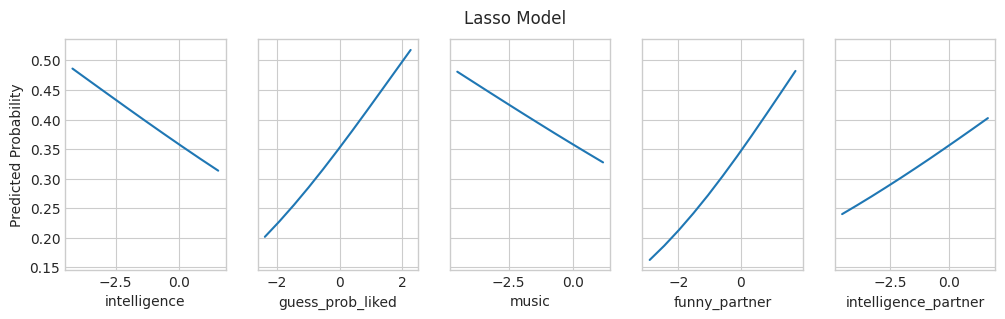

In [65]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig,axes = plt.subplots(1,5,sharey=True,figsize = (12,3))
    for n,f in enumerate(feats_comp_lasso):
        _,pdep = calculate_partial_dependence(f,X_test_f[selected_feats],lasso,selected_feats)
        pdep['Partial Dependence'] = pdep['Partial Dependence'] #- pdep['Partial Dependence'].iloc[0] #Para que sean más comparables visualmente
        sns.lineplot(data=pdep,x=pdep.index,y='Partial Dependence',ax = axes[n])
    axes[0].set_ylabel('Predicted Probability')
    fig.suptitle('Lasso Model')
    save_path = 'Plots//pdp_lasso_f.jpeg'
    #plt.savefig(save_path,dpi=300,bbox_inches='tight')

Gradient Boosting

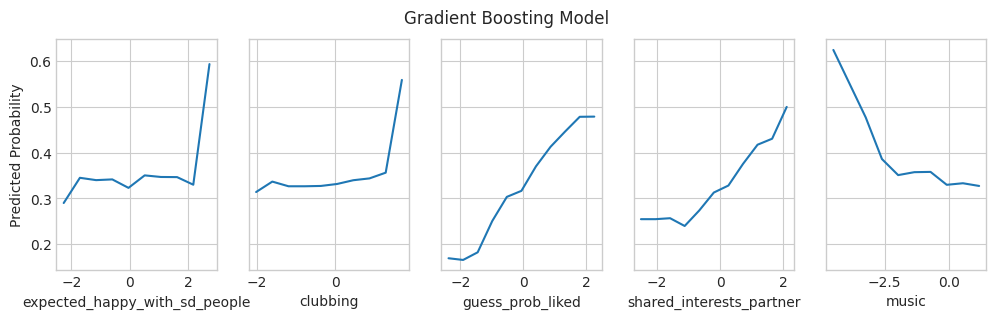

In [66]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig,axes = plt.subplots(1,5,sharey=True,figsize = (12,3))
    for n,f in enumerate(feats_comp_gb):
        _,pdep = calculate_partial_dependence(f,X_test_f[original_features],gb)
        pdep['Partial Dependence'] = pdep['Partial Dependence'] #- pdep['Partial Dependence'].iloc[0] #Para que sean más comparables visualmente
        sns.lineplot(data=pdep,x=pdep.index,y='Partial Dependence',ax = axes[n])
    axes[0].set_ylabel('Predicted Probability')
    fig.suptitle('Gradient Boosting Model')
    save_path = 'Plots//pdp_gb_f.jpeg'
    #plt.savefig(save_path,dpi=300,bbox_inches='tight')

Features from paper

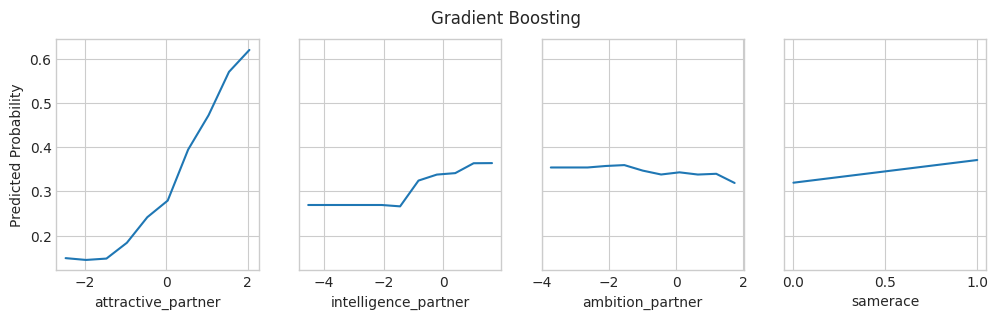

In [68]:
with plt.style.context('seaborn-v0_8-whitegrid'): #GB
    fig,axes = plt.subplots(1,4,sharey=True,figsize = (12,3))
    for n,f in enumerate(feats_paper):
        _,pdep_gb = calculate_partial_dependence(f,X_test_f[original_features],gb)
        sns.lineplot(data=pdep_gb,x=pdep_gb.index,y='Partial Dependence',ax = axes[n])
    axes[0].set_ylabel('Predicted Probability')
    fig.suptitle('Gradient Boosting')
    save_path = 'Plots//pdp_paper_gb_f.jpeg'
   # plt.savefig(save_path,dpi=300,bbox_inches='tight')

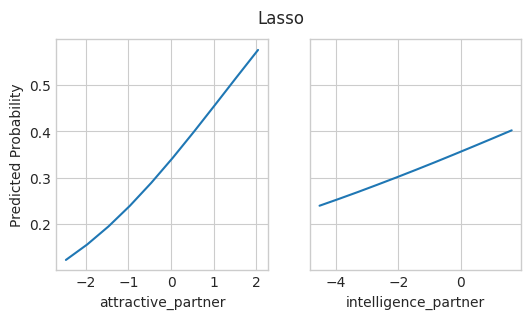

In [69]:
with plt.style.context('seaborn-v0_8-whitegrid'): #Lasso
    fig,axes = plt.subplots(1,2,sharey=True,figsize = (6,3))
    for n,f in enumerate(['attractive_partner','intelligence_partner']):
        try:
            _,pdep_l = calculate_partial_dependence(f,X_test_f[selected_feats],lasso,selected_feats)
            sns.lineplot(data=pdep_l,x=pdep_l.index,y='Partial Dependence',ax = axes[n])
        except:
            pass
    axes[0].set_ylabel('Predicted Probability')
    fig.suptitle('Lasso')
    save_path = 'Plots//pdp_paper_lasso_f.jpeg'
    #plt.savefig(save_path,dpi=300,bbox_inches='tight')

Biggest predicted probability changes

In [70]:
print('Lasso')
for l in sorted(max_longitud_l.items(),key = lambda item: item[1])[-6:]:
    print(l)
print('GB')
for g in sorted(max_longitud_gb.items(),key = lambda item: item[1])[-6:]:
    print(g)

Lasso
('music', 0.15339999999999998)
('intelligence_partner', 0.1624)
('intelligence', 0.17270000000000002)
('guess_prob_liked', 0.31610000000000005)
('funny_partner', 0.3197)
('attractive_partner', 0.4524)
GB
('clubbing', 0.24500000000000005)
('shared_interests_partner', 0.2602)
('music', 0.2972)
('expected_happy_with_sd_people', 0.3036)
('guess_prob_liked', 0.31320000000000003)
('attractive_partner', 0.47580000000000006)


## Extra: We run regressions similar to theirs (although they used a linear probability model and tested performance using R-squared, not kappa)

In [71]:
# Not the same exact features!
X_paper = X_train_f[['ambition','ambition_partner','attractive','attractive_partner','intelligence','intelligence_partner','samerace']].copy()
X_test_paper = X_test_f[['ambition','ambition_partner','attractive','attractive_partner','intelligence','intelligence_partner']].copy()
for f in X_paper.columns:
    if not 'partner' in f and f != 'samerace':
        X_paper[f'{f}_partner > {f}'] = np.where(X_paper[f] < X_paper[f'{f}_partner'],1,0)
        X_test_paper[f'{f}_partner > {f}'] = np.where(X_test_paper[f] < X_test_paper[f'{f}_partner'],1,0)



In [72]:
cols_1 = ['ambition_partner','intelligence_partner','ambition_partner'] #1st regression

In [73]:
paper_lr_0 = LogisticRegression()
paper_lr_0.fit(X_paper[cols_1],y_train_f)

LogisticRegression()

In [74]:
paper_lr_1 = LogisticRegression()
paper_lr_1.fit(X_paper.drop(columns='samerace'),y_train_f)

LogisticRegression()

In [76]:
model_scores = dict(
    kappa = [],
    accuracy = []
)
models = dict(
    Lasso = [lasso,selected_feats,X_test_f],
    Gradient_Boosting = [gb,original_features,X_test_f],
    Reg_0 = [paper_lr_0,cols_1,X_test_f],
    Reg_1 = [paper_lr_1,X_paper.drop(columns='samerace').columns,X_test_paper]

)
for model_name,params in models.items():
    y_pred = params[0].predict(params[2][params[1]])
    model_scores['kappa'].append(np.round(cohen_kappa_score(y_pred,y_test_f),2))
    model_scores['accuracy'].append(np.round(accuracy_score(y_pred,y_test_f),2))

In [77]:
pd.DataFrame(model_scores,index=models.keys()).T #Keep in mind, results may differ a bit in our research paper (the test split is different)

,Lasso,Gradient_Boosting,Reg_0,Reg_1
kappa,0.59,0.65,0.11,0.45
accuracy,0.81,0.84,0.65,0.75


Samerace is discarded since there is no data on "sameregion" and it wouldn't be comparable